In [7]:

import os

def read_obj_file(file_path):
    """
    Reads a .obj file and returns lists of vertices and faces.
    
    Args:
        file_path (str): Path to the .obj file.

    Returns:
        vertices (list of tuple): List of (x, y, z) tuples representing vertices.
        faces (list of list): List of faces, each face is a list of vertex indices (1-based as in .obj).
    """
    vertices = []
    faces = []

    # Just use the path as given, and print for debug if file not found
    if not os.path.isfile(file_path):
        print(f"Warning: .obj file not found at '{os.path.abspath(file_path)}' (relative: '{file_path}').")
        print("Current working directory:", os.getcwd())
        try:
            print("Contents of directory:", os.listdir(os.path.dirname(file_path)))
        except Exception as e:
            print("Could not list directory due to:", e)
        return vertices, faces

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("v "):
                parts = line.split()
                # vertex: v x y z
                try:
                    x, y, z = map(float, parts[1:4])
                    vertices.append((x, y, z))
                except ValueError:
                    continue
            elif line.startswith("f "):
                parts = line.split()
                # face: f v1 v2 v3 ...
                face = []
                for idx in parts[1:]:
                    if '/' in idx:
                        v_idx = idx.split('/')[0]
                    else:
                        v_idx = idx
                    try:
                        face.append(int(v_idx))
                    except ValueError:
                        continue
                if len(face) >= 3:
                    faces.append(face)
    return vertices, faces

IN_OBJ_PATH = "input/Hitem3D_Model_Generator/model.obj"
print("Trying to load OBJ from:", IN_OBJ_PATH)
preprocessed = read_obj_file(IN_OBJ_PATH)
preprocessed_pcl = preprocessed[0]
print("First 10 points:", preprocessed_pcl[:10])


Trying to load OBJ from: input/Hitem3D_Model_Generator/model.obj
First 10 points: [(-0.58546102, -0.20515101, -0.056282), (-0.58541101, -0.205139, -0.062015), (-0.58533502, -0.204878, -0.056374), (-0.585302, -0.205162, -0.051799), (-0.58522803, -0.205578, -0.057022), (-0.58512801, -0.205529, -0.063943), (-0.58510798, -0.2049, -0.064599), (-0.58499998, -0.20555, -0.049901), (-0.58490902, -0.204824, -0.057861), (-0.58487499, -0.205191, -0.071022)]


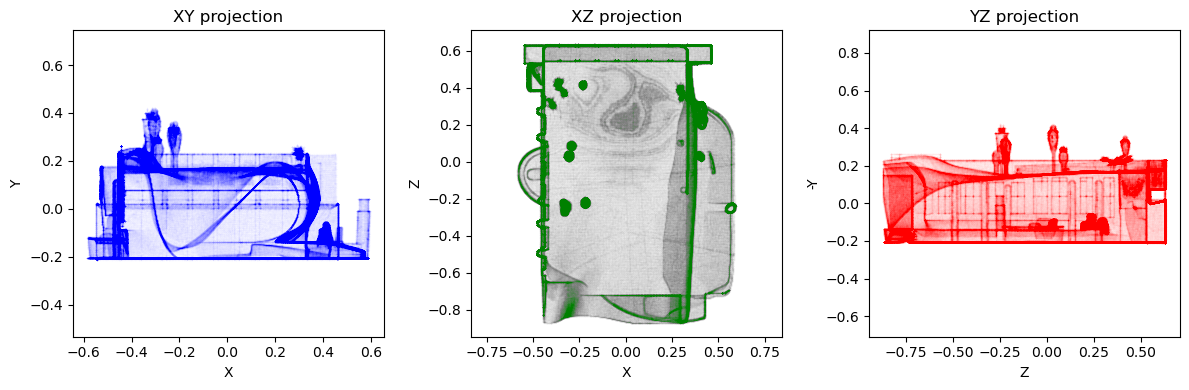

In [8]:
import matplotlib.pyplot as plt

# Assuming preprocessed_pcl is a list of (x, y, z) tuples
import numpy as np

points = np.array(preprocessed_pcl)

fig = plt.figure(figsize=(12, 4))

# XY projection (z ignored)
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(points[:, 0], points[:, 1], alpha=0.002, c='b', s=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('XY projection')
ax1.axis('equal')

# XZ projection (y ignored)
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(points[:, 0], points[:, 2], alpha=0.002, c='g', s=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('XZ projection')
ax2.axis('equal')

# YZ projection (x ignored)
ax3 = fig.add_subplot(1, 3, 3)
# Rotate the YZ projection by 90 degrees (counter-clockwise)
ax3.scatter(points[:, 2], points[:, 1], alpha=0.002, c='r', s=1)
ax3.set_xlabel('Z')
ax3.set_ylabel('-Y')
ax3.set_title('YZ projection')
ax3.axis('equal')

plt.tight_layout()
plt.show()


Difference between highest and lowest X elements: 1.18056804
Difference between highest and lowest Y elements: 0.6357499799999999


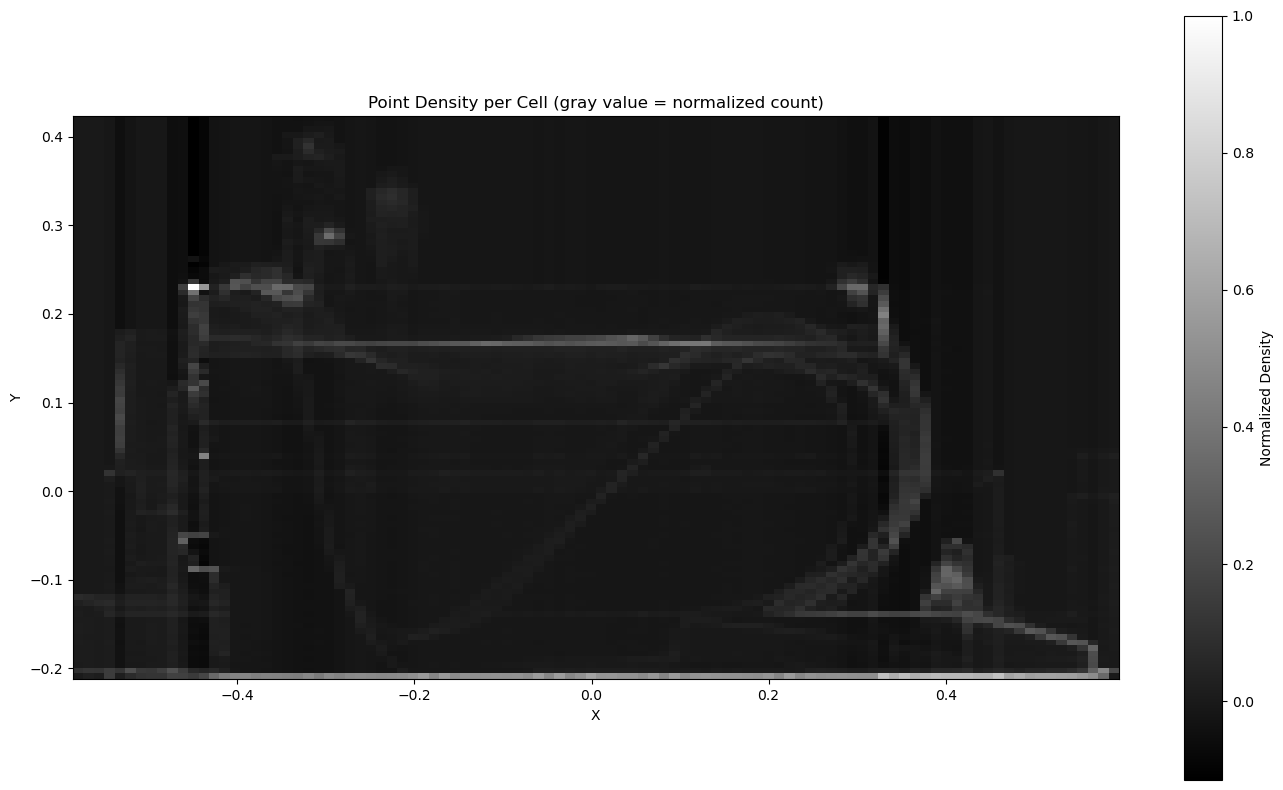

In [22]:
# Rewritten to be robust to missing definitions, guard imports, and raise clear errors if missing data

import numpy as np

def loss_function(x):
    """Compute mean squared error from mean."""
    x = np.asarray(x)
    mean = np.mean(x)
    mse = np.sum((x - mean) ** 2)
    return mse

# Ensure `preprocessed_pcl` exists in the notebook environment
try:
    preprocessed_pcl
except NameError:
    raise NameError("The variable 'preprocessed_pcl' is not defined. Please ensure it is created earlier in the notebook.")

# Ensure numpy is imported as np
if 'np' not in globals():
    import numpy as np

points = np.array(preprocessed_pcl)

xy_projection = points[:, :2]  # Take the first two columns: projection on XY

size = (100, 100)

# Compute min and max in X and Y for binning
x_min, x_max = np.min(xy_projection[:, 0]), np.max(xy_projection[:, 0])
y_min, y_max = np.min(xy_projection[:, 1]), np.max(xy_projection[:, 1])

x_difference = x_max - x_min
y_difference = y_max - y_min

print("Difference between highest and lowest X elements:", x_difference)
print("Difference between highest and lowest Y elements:", y_difference)

cell_counts = np.zeros(size, dtype=int)

# Compute which cell each point belongs to
x_bins = np.linspace(x_min, x_max, size[0]+1)
y_bins = np.linspace(y_min, y_max, size[1]+1)

# Use numpy digitize to get cell indices
x_indices = np.digitize(xy_projection[:, 0], x_bins) - 1   # 0-based
y_indices = np.digitize(xy_projection[:, 1], y_bins) - 1   # 0-based

# Filter out indices that fall just on the right/top edge, clamp to valid range
x_indices = np.clip(x_indices, 0, size[0]-1)
y_indices = np.clip(y_indices, 0, size[1]-1)

# Compute density difference feature for each cell
for xi, yi in zip(x_indices, y_indices):
    cell_counts[xi, yi] += 1

# Create a new array for the "horizontal density difference" per cell
density_diff = np.zeros_like(cell_counts, dtype=float)

# The feature: difference from the mean density in the same row (horizontal line)
row_means = cell_counts.mean(axis=1, keepdims=True)
density_diff = cell_counts - row_means

# Now density_diff[xi, yi] > 0 means excess points at (xi, yi) relative to the average of its row.
# Pattern: if many cells in a row have high density_diff, indicates horizontal band/stripe of points.

# If you want just the density difference in each cell (relative to average for its row, i.e. horizontal pattern):
cell_counts = density_diff

# cell_counts[i, j] gives the number of points in cell (i, j)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
# Normalize cell counts to [0, 1] for alpha (opacity)
norm_counts = cell_counts.T.astype(float)  # .T because imshow expects row,col (y,x)

if norm_counts.max() > 0:
    norm_counts = norm_counts / norm_counts.max()
else:
    norm_counts = np.zeros_like(norm_counts)

# --- IMAGES AND COLORMAP FOR DENSITY ---
ax = plt.gca()
# Show background at low alpha (for reference)
ax.imshow(
    np.ones_like(norm_counts),  # white base
    cmap='gray',
    interpolation='none',
    extent=(x_min, x_max, y_min, y_max),
    alpha=0.1,
    origin="lower"
)
# Display density as grayscale, each pixel alpha is the normalized count (will look like ghost image)
density_img = ax.imshow(
    norm_counts,       # This time show actual density ("opacity map")
    cmap='gray',
    interpolation='none',
    extent=(x_min, x_max, y_min, y_max),
    alpha=1.0,
    origin="lower"
)

plt.title("Point Density per Cell (gray value = normalized count)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(
    density_img,
    label="Normalized Density"
)
plt.tight_layout()
plt.show()





[]


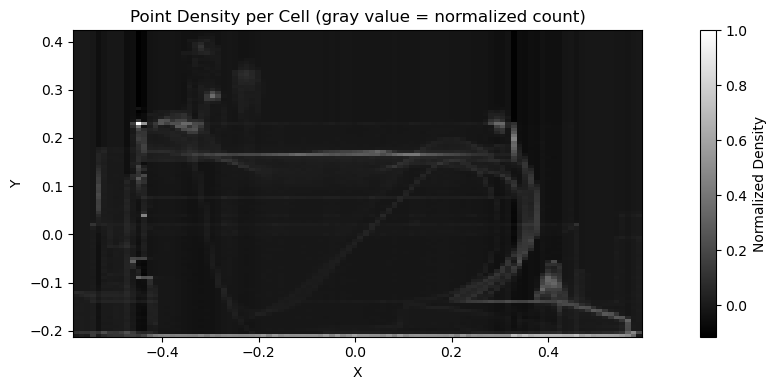

: 

In [ ]:
# -*- coding: utf-8 -*-
# Поиск горизонтальных линий «ядром линии» фиксированной длины L.
# Идея: двоим маску по порогу, затем скользящее окно длиной L считает,
# сколько пикселей окна попало в маску. Если сумма >= L - allow_gaps,
# считаем, что в этом месте есть горизонтальный отрезок. Дальше сливаем
# пересекающиеся окна в конечные сегменты. Есть опция визуализации.

import numpy as np
import matplotlib.pyplot as plt
from pandas._libs.tslibs import ccalendar

def find_horizontal_lines_kernel(img: np.ndarray,
                                 thr: float,
                                 L: int,
                                 allow_gaps: int = 0,
                                 merge_tol: int = 1):
    """
    img         : 2D ndarray (float/uint8) — входное изображение/карта
    thr         : порог бинаризации (img >= thr -> «пиксель линии»)
    L           : длина линейного ядра (кол-во пикселей по горизонтали)
    allow_gaps  : допускаемое число «дыр» внутри окна длины L
    merge_tol   : при склейке соседних окон, максимум пикселей между ними, чтобы объединить

    Возвращает список сегментов: (row, col_start, col_end, length).
    """
    assert L > 0 and allow_gaps >= 0 and merge_tol >= 0
    H, W = img.shape[:2]
    mask = (img >= thr).astype(np.uint8)

    kernel = np.ones(L, dtype=np.int32)            # ядро линии длиной L
    need_sum = max(1, L - int(allow_gaps))         # минимальная сумма в окне

    segments = []
    # Проходимся по строкам (каждая строка — 1D сигнал)
    for r in range(H):
        row = mask[r]
        # скользящая сумма по окну длиной L (позиции — по левому краю окна)
        # используем 'valid', чтобы сумма соответствовала полному окну
        s = np.convolve(row.astype(np.int32), kernel, mode='valid')
        # индикатор «в окне есть линия» с учётом allow_gaps
        win_ok = (s >= need_sum).astype(np.uint8)

        if not np.any(win_ok):
            continue

        # Находим пробеги единиц и конвертируем обратно в координаты колонок
        # Индексы win_ok относятся к левому краю окна, поэтому сегмент = [i, i+L)
        padded = np.pad(win_ok, (1, 1))
        d = np.diff(padded)
        starts = np.where(d == 1)[0]      # включительно
        ends   = np.where(d == -1)[0]     # исключительно

        # Превращаем окна в сегменты по колонкам
        runs = [[int(cs), int(ce + L - 1)] for cs, ce in zip(starts, ends)]  # закрытый интервал [cs, ce+L-1]

        # Склеиваем перекрывающиеся/почти-соседние сегменты (merge_tol пикселей между ними)
        runs.sort()
        merged = []
        for cs, ce in runs:
            if not merged:
                merged.append([cs, ce])
                continue
            p_cs, p_ce = merged[-1]
            if cs <= p_ce + 1 + merge_tol:
                merged[-1][1] = max(p_ce, ce)
            else:
                merged.append([cs, ce])

        # Записываем финальные сегменты (длина в пикселях = ce - cs + 1)
        for cs, ce in merged:
            length = ce - cs + 1
            if length >= L:  # гарантируем не короче ядра
                segments.append((r, cs, ce + 1, length))  # col_end делаем полуоткрытым (удобно для отрисовки)

    return segments


cc = np.asarray(cell_counts)  # если вдруг это не ndarray
L = 1             # длина «линейного» ядра
thr = 0.1           # порог бинаризации
allow_gaps = 3      # сколько дыр допускаем внутри окна длиной L
merge_tol = 2       # склеивать близкие окна (для устойчивости)
lines = find_horizontal_lines_kernel(cc, thr=thr, L=L, allow_gaps=allow_gaps, merge_tol=merge_tol)
print(lines)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
# Show cc as a transparent grayscale image in the background
density_img = ax.imshow(
    norm_counts,       # This time show actual density ("opacity map")
    cmap='gray',
    interpolation='none',
    extent=(x_min, x_max, y_min, y_max),
    alpha=1.0,
    origin="lower"
)


# --- Spawn (draw) found "lines" on top ---
x_pixel_size = (x_max - x_min) / cc.shape[1]
y_pixel_size = (y_max - y_min) / cc.shape[0]

for (row, col_start, col_end, L) in lines:
    y = y_min + row * y_pixel_size + y_pixel_size / 2
    x1 = x_min + col_start * x_pixel_size
    x2 = x_min + col_end * x_pixel_size
    ax.plot([x1, x2], [y, y], color='lime', linewidth=1, alpha=0.85)

plt.title("Point Density per Cell (gray value = normalized count)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(
    density_img,
    label="Normalized Density"
)
plt.tight_layout()
plt.show()